In [1]:
import numpy as np
import matplotlib.pyplot as plt
from vespainv.model import VespaModel, Prior
from vespainv.waveformBuilder import create_U_from_model

In [5]:
# --- Time and STF setup ---
dt = 0.01
time = np.arange(-10, 30, dt)
stf_time = np.arange(-1, 1, dt)
stf = np.exp(-((stf_time / 0.2)**2))  # Gaussian STF

In [6]:
# --- Synthetic model setup ---
# model = VespaModel.create_empty(Nphase=1, Ntrace=5)
# model.arr[0] = 10.0      # arrival at 10s
# model.slw[0] = 0.05      # s/deg
# model.amp[0] = 1.0       # unit amplitude
# model.distDiff[0] = 0.0
# model.bazDiff[0] = 0.0

In [7]:
# --- Station metadata with small perturbations ---
np.random.seed(0)
base_dist = 35.0
base_baz = 70.0
Ntrace = 10
dists = base_dist + np.random.uniform(-0.0, 0.0, Ntrace)
bazs = base_baz + np.random.uniform(-10.0, 10.0, Ntrace)
station_metadata = np.column_stack((dists, bazs))

# --- Prior ---
prior = Prior(refLat = 0., refLon = 0.,refBaz=base_baz, timeRange=(time[0],time[-1]))

In [15]:
model = VespaModel.create_random(Nphase=3, Ntrace=Ntrace, time=time, prior=prior)
print(model)

VespaModel(Nphase=3, Ntrace=10, arr=array([27.74048566, 17.26599376,  4.37672094]), slw=array([-0.02518722,  0.07905248, -0.17590981]), amp=array([ 0.33353343,  0.34127574, -0.57923488]), distDiff=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), bazDiff=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))


In [16]:
# --- Generate synthetic seismograms ---
U = create_U_from_model(model, prior, station_metadata, time, stf_time, stf)


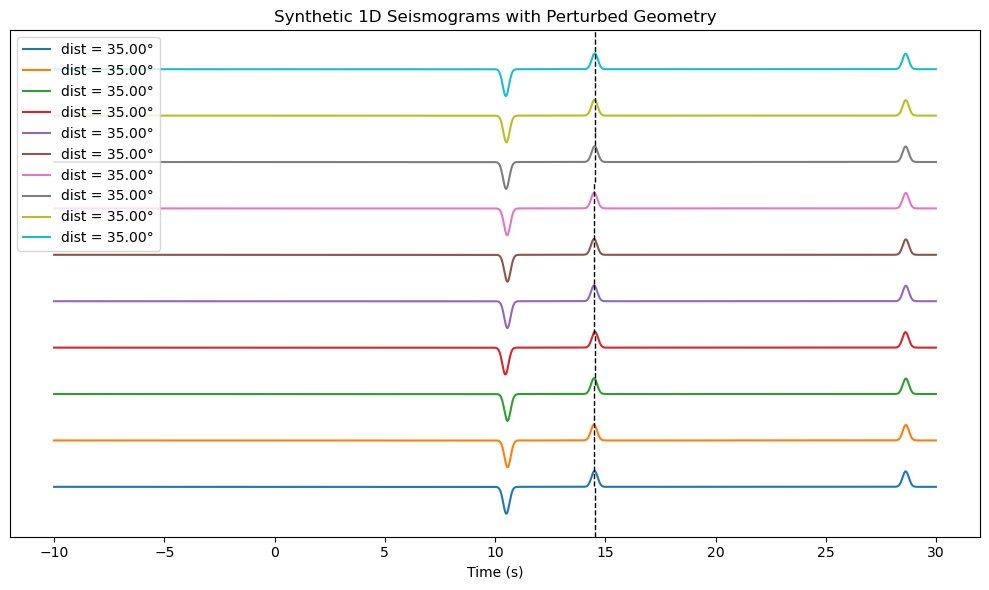

In [17]:
# --- Plot ---
plt.figure(figsize=(10, 6))
for i in range(U.shape[0]):
    trace = U[i]
    plt.plot(time, trace + i, label=f'dist = {dists[i]:.2f}°')

    # Find peak time
    peak_idx = np.argmax(trace)
    peak_time = time[peak_idx]
    plt.axvline(x=peak_time, ymin=i / U.shape[0], ymax=(i + 1) / U.shape[0],
                color='k', linestyle='--', linewidth=1)

plt.xlabel("Time (s)")
plt.title("Synthetic 1D Seismograms with Perturbed Geometry")
plt.yticks([])
plt.legend()
plt.tight_layout()
# plt.xlim(5, 15)
plt.show()


In [11]:
from vespainv.utils import dest_point

lat1 = 4.5
lon1 = 135.9
baz = 77
dist = 28.7

lat2, lon2 = dest_point(lat1, lon1, baz, dist)
print(lat2, lon2)

10.16676782304183 164.28407774089493


VespaModel3c(Nphase=3, Ntrace=50, arr=array([30, 60, 90], dtype=int32), slw=array([0.02454388, 0.08035901, 0.01963813]), amp=array([0.8287552 , 0.70370466, 0.91950144]), dip=array([36.93019552, 79.27927648, 77.15441276]), azi=array([121.49896421,  13.30787306,  18.47498263]), ph_hh=array([ 19.644717  ,   9.16823693, -86.64641769]), ph_vh=array([-14.04101018, -69.63250878,  80.29103658]), atts=array([3.16267135, 0.98050581, 2.80151043]), svfac=array([0.75064144, 0.59597878, 0.63114388]), wvtype=array([1, 1, 0], dtype=int32), distDiff=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), bazDiff=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))


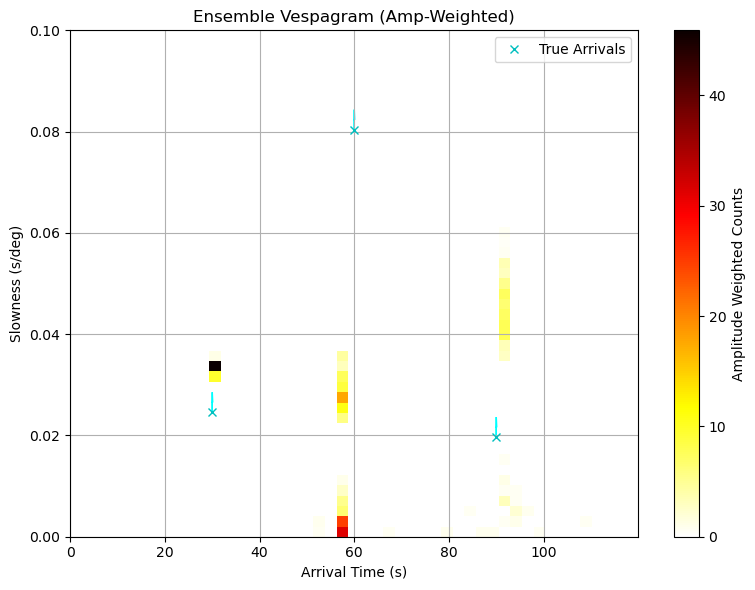

In [1]:
from vespainv.visualization import plot_ensemble_vespagram
import pickle, os
import numpy as np

synDir = "./synData/model3/"
resDir = "./runs/syn/model3/run2.1_T=0.1_freq/"

with open(os.path.join(resDir, "ensemble.pkl"), "rb") as f:
    ensemble = pickle.load(f)
with open(os.path.join(synDir, "synPrior.pkl"), "rb") as f:
    prior = pickle.load(f)
with open(os.path.join(synDir, "synModel.pkl"), "rb") as f:
    model = pickle.load(f)
Utime  = np.loadtxt(os.path.join(synDir, "time_syn.csv"), delimiter=",")  # columns: time

plot_ensemble_vespagram(ensemble, Utime, prior, amp_weighted=True, true_model=model)
print(model)

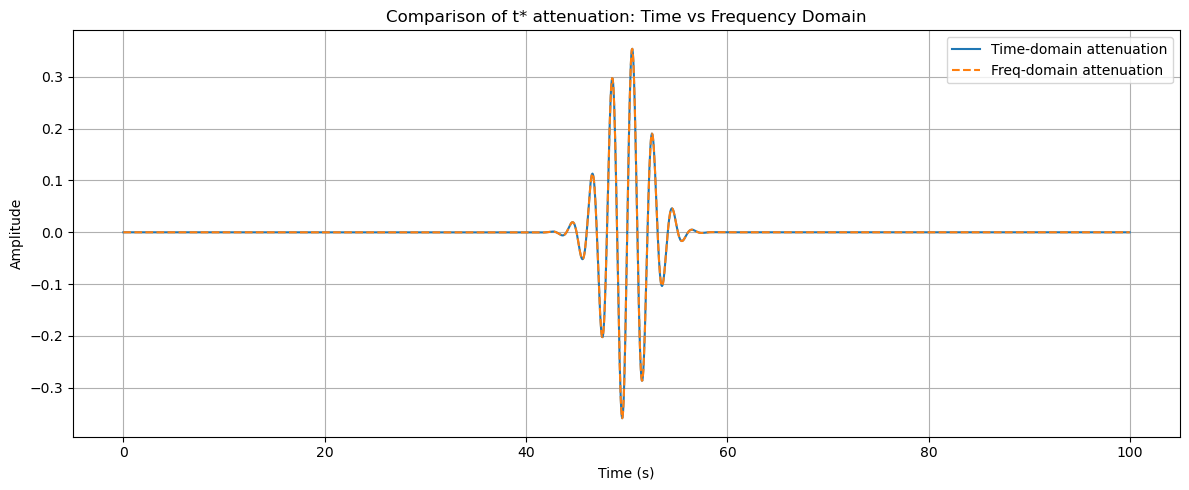

In [30]:
import numpy as np
from vespainv.waveformBuilder import tstar_conv

def tstar_conv_freqdomain(W: np.ndarray, freqs: np.ndarray, t_star: float) -> np.ndarray:
    """
    Apply t* attenuation in the frequency domain.

    Parameters:
    - W: Fourier-transformed waveform (1D complex array)
    - freqs: frequency array corresponding to W
    - t_star: t* value

    Returns:
    - W_attenuated: Attenuated waveform in frequency domain
    """
    f = freqs * t_star
    f0 = 1.0 * t_star  # reference frequency
    f_f0 = f / f0

    # Create attenuation operator
    attenuation = np.exp(-np.pi * f) * np.power(
        f_f0, 1j * 2 * f, where=f_f0 > 0, out=np.zeros_like(f_f0, dtype=complex)
    )
    W_attenuated = W * attenuation
    W_attenuated[0] = 0  # Zero the DC component

    return W_attenuated

# === Cross check ===
import matplotlib.pyplot as plt

# Create test waveform
dt = 0.05
N = 2000
time = np.arange(N) * dt
f0 = 0.5  # dominant frequency
wvfm = np.sin(2 * np.pi * f0 * time) * np.exp(-((time - 50)**2) / 10)

# FFT of original waveform
W = np.fft.fft(wvfm)
freqs = np.fft.fftfreq(N, dt)

# Apply both methods
t_star = 0.2
wvfm_att_time = tstar_conv(wvfm, time, t_star)
W_att = tstar_conv_freqdomain(W, freqs, t_star)
wvfm_att_freq = np.fft.ifft(W_att).real

# Plot comparison
plt.figure(figsize=(12, 5))
plt.plot(time, wvfm_att_time, label="Time-domain attenuation")
plt.plot(time, wvfm_att_freq, label="Freq-domain attenuation", linestyle='--')
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Comparison of t* attenuation: Time vs Frequency Domain")
plt.grid(True)
plt.tight_layout()
plt.show()


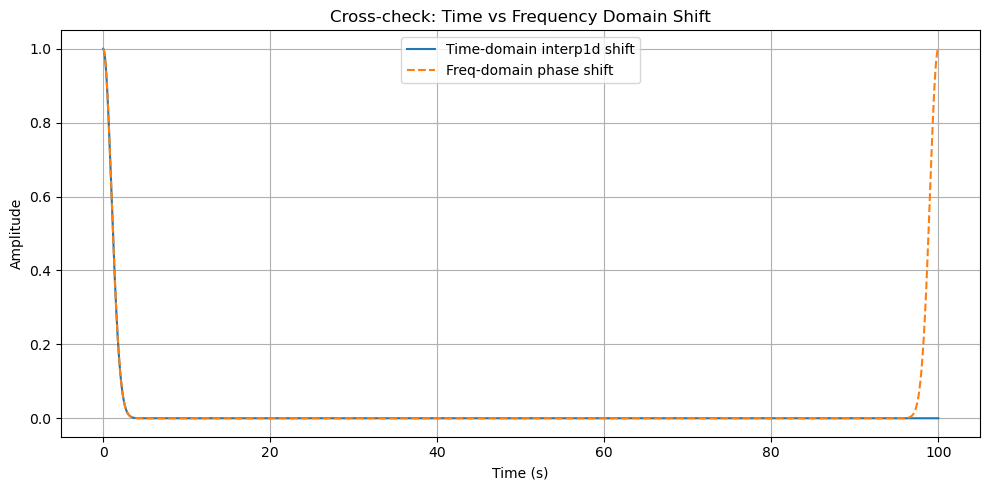

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.fft import fft, ifft, fftfreq

# Parameters
dt = 0.01
N = 1000          # Length of original waveform
Nlong = 10000     # Length of target waveform (longer to hold shift)
time = np.arange(N) * dt  # Original time vector
timelong = np.arange(Nlong) * dt  # Target time vector
freq_long = fftfreq(Nlong, dt)

tshift = -5  # seconds

# Generate test waveform (Gaussian pulse)
center = 5.0
width = 1.0
P_wvlt = np.exp(-((time - center) ** 2) / (2 * width ** 2))

# ----------------------------
# TIME-DOMAIN INTERPOLATION SHIFT
# ----------------------------
# Interpolate with shifted time vector and evaluate at timelong
P_shifted_time = interp1d(
    time + tshift,
    P_wvlt,
    kind='linear',
    bounds_error=False,
    fill_value=0.0
)(timelong)

# ----------------------------
# FREQUENCY-DOMAIN PHASE SHIFT
# ----------------------------
# Zero-pad P_wvlt to match Nlong
P_wvlt_padded = np.pad(P_wvlt, (0, Nlong - N))

# FFT of the zero-padded waveform
P_wvlt_W = fft(P_wvlt_padded)

# Apply phase shift in frequency domain
phase_shift = np.exp(-2j * np.pi * freq_long * tshift)
P_wvlt_W_shifted = P_wvlt_W * phase_shift

# IFFT to get back the time-domain waveform
P_shifted_freq = np.real(ifft(P_wvlt_W_shifted))

# ----------------------------
# PLOT FOR CROSS-CHECK
# ----------------------------
plt.figure(figsize=(10, 5))
plt.plot(timelong, P_shifted_time, label='Time-domain interp1d shift')
plt.plot(timelong, P_shifted_freq, '--', label='Freq-domain phase shift')
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Cross-check: Time vs Frequency Domain Shift")
plt.grid(True)
plt.tight_layout()
plt.show()


In [4]:
from vespainv.utils import prepare_inputs_from_sac
data_dir = "/Users/evanzhang/Documents/Research/fetchData/event_download/201111221848/"
output_dir = "/Users/evanzhang/Documents/Research/VespaPolPy/RealData/201111221848/"
prepare_inputs_from_sac(data_dir, output_dir)

Saved data to: /Users/evanzhang/Documents/Research/VespaPolPy/RealData/201111221848/


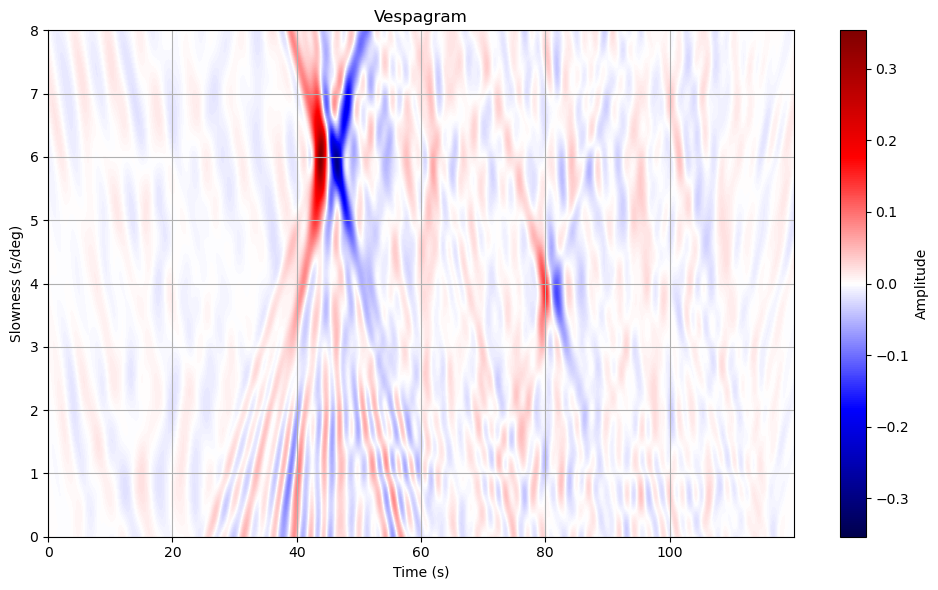

array([[ 5.22489861e-04,  5.23908724e-04,  5.25210140e-04, ...,
        -1.40761954e-07, -3.18356259e-08, -3.62561302e-09],
       [ 5.59160078e-04,  6.19627417e-04,  6.05663459e-04, ...,
        -3.37381091e-07, -9.73912287e-08, -8.98743510e-09],
       [ 5.59642060e-04,  6.07467877e-04,  6.22066295e-04, ...,
        -7.53387389e-07, -2.22683421e-07,  4.87941653e-08],
       ...,
       [ 2.74077475e-03,  2.43442272e-03,  2.12274833e-03, ...,
        -4.45550212e-04, -7.30261526e-05,  2.98499694e-04],
       [ 1.74522270e-03,  1.43715482e-03,  1.12476487e-03, ...,
        -1.43937067e-03, -1.06950090e-03, -6.99142330e-04],
       [ 7.62207391e-04,  4.55670528e-04,  1.45882006e-04, ...,
        -2.37703117e-03, -2.01471069e-03, -1.65044389e-03]])

In [31]:
from vespainv.utils import make_vespagram, dest_point, bandpass
import numpy as np
import os, pickle

isSyn = False
evname = "201111221848"
Uname = "UZ.csv"
slow_grid = np.linspace(0,8,201)
isbp = True
freqs = np.array([0.02, 0.5])

if isSyn:
    datadir = "./SynData/"
else:
    datadir = "./RealData/"

U_obs = np.loadtxt(os.path.join(datadir, evname, Uname), delimiter=",")  # columns: data
Utime = np.loadtxt(os.path.join(datadir, evname, "time.csv"), delimiter=",")  # columns: time
metadata = np.loadtxt(os.path.join(datadir, evname, "station_metadata.csv"), delimiter=",", skiprows=1)

if isbp:
    U_obs = bandpass(U_obs, 1/(Utime[1]-Utime[0]), freqs[0], freqs[1])

if isSyn:
    with open(os.path.join(datadir, evname, "synPrior.pkl"), "rb") as f:
        prior = pickle.load(f)
    refLat = prior.refLat
    refLon = prior.refLon
    srcLat = prior.srcLat
    srcLon = prior.srcLon
    refBaz = prior.refBaz
else:
    srcLat, srcLon = np.loadtxt(os.path.join(datadir, evname, "eventinfo.csv"), delimiter=",", skiprows=1)
    refLat, refLon = dest_point(srcLat, srcLon, np.mean(metadata[:,1]), np.mean(metadata[:,0]))

make_vespagram(U=U_obs, time=Utime, metadata=metadata, refLat=refLat, refLon=refLon, srcLat=srcLat, srcLon=srcLon, slow_grid=slow_grid)

Dominant frequency:  0.37 Hz
Dominant frequency:  0.37 Hz
Dominant frequency:  0.40 Hz
Dominant frequency:  0.40 Hz
Dominant frequency:  0.40 Hz
Dominant frequency:  0.41 Hz
Dominant frequency:  0.35 Hz
Dominant frequency:  0.46 Hz
Dominant frequency:  0.48 Hz
Dominant frequency:  0.50 Hz
Dominant frequency:  0.50 Hz
Dominant frequency:  0.54 Hz
Dominant frequency:  0.42 Hz
Dominant frequency:  0.47 Hz
Dominant frequency:  0.45 Hz
Dominant frequency:  0.47 Hz
Dominant frequency:  0.45 Hz
Dominant frequency:  0.52 Hz
Dominant frequency:  0.48 Hz
Dominant frequency:  0.41 Hz
Dominant frequency:  0.53 Hz
Dominant frequency:  0.55 Hz
Dominant frequency:  0.51 Hz
Dominant frequency:  0.35 Hz
Dominant frequency:  0.44 Hz
Dominant frequency:  0.41 Hz
Dominant frequency:  0.53 Hz
Dominant frequency:  0.51 Hz
Dominant frequency:  0.56 Hz
Dominant frequency:  0.63 Hz
Dominant frequency:  0.55 Hz
Dominant frequency:  0.58 Hz
Dominant frequency:  0.49 Hz
Dominant frequency:  0.60 Hz
Dominant frequ

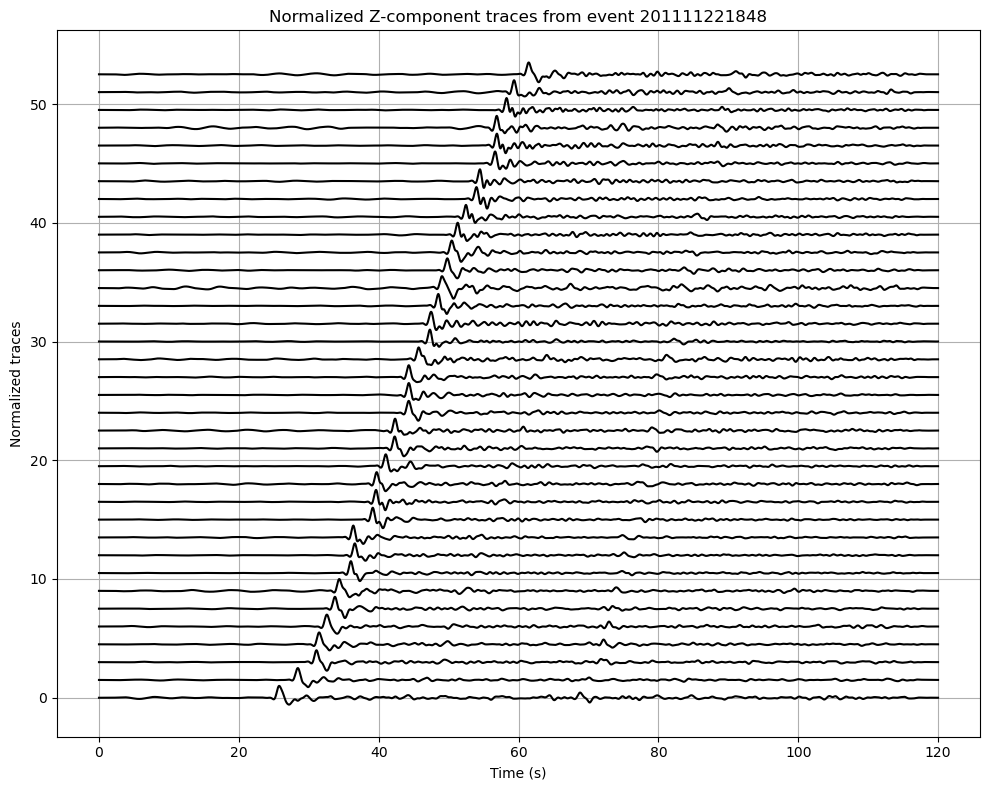

0.019424001971133933


In [33]:
import numpy as np
import matplotlib.pyplot as plt
import os
from vespainv.utils import est_dom_freq, bandpass

# Load data
evname = "201111221848"
U_obs = np.loadtxt(os.path.join("./RealData/", evname, "UZ.csv"), delimiter=",")
Utime = np.loadtxt(os.path.join("./RealData/", evname, "time.csv"), delimiter=",")

isbp = True
freqs = (0.02, 1.0)

if isbp:
    U_obs = bandpass(U_obs, 1/(Utime[1]-Utime[0]), freqs[0], freqs[1])

# Plot
plt.figure(figsize=(10, 8))
n_traces = U_obs.shape[1]
offset = 1.5  # vertical offset between traces

f0 = np.array([])

for i in range(n_traces):
    trace = U_obs[:, i]
    f0 = np.append(f0, est_dom_freq(trace, 1/(Utime[1]-Utime[0])))
    norm_trace = trace / np.max(np.abs(trace))
    plt.plot(Utime, norm_trace + i * offset, color='black')

print(f"Mean f₀: {np.mean(f0):.2f} Hz")
print(f"Median f₀: {np.median(f0):.2f} Hz")
print(f"Std dev of f₀: {np.std(f0):.2f} Hz")

plt.xlabel("Time (s)")
plt.ylabel("Normalized traces")
plt.title(f"Normalized Z-component traces from event {evname}")
plt.grid(True)
plt.tight_layout()
plt.show()

print(np.std(norm_trace[0:800]))


In [11]:
isSyn = False
modname = "200705062111"
runname = "run3_Z"

if isSyn:
    datadir = "./SynData"
    saveDir = os.path.join("./runs/syn/", modname, runname)
else:
    datadir = "./RealData"
    saveDir = os.path.join("./runs/data/", modname, runname)

with open(os.path.join(datadir, modname, "Prior.pkl"), "rb") as f:
    prior = pickle.load(f)

print(prior.srcLat, prior.srcLon, prior.refLat, prior.refLon, prior.refBaz)

-19.46809959411621 -179.32879638671875 42.169663949784734 -117.3675861057776 41.1313639151751


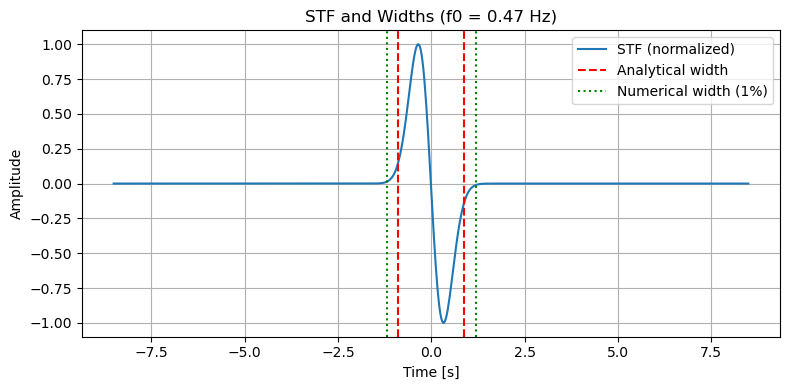

Analytical width ≈ 1.7609 s
Numerical width (above 1%) ≈ 2.4000 s


In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Your original function
def create_stf(f0, dt):
    stf_time_0 = np.arange(-4 / f0, 4 / f0 + dt, dt)
    stf_0 = np.exp(-stf_time_0 ** 2 / (2 * (1 / (2 * np.pi * f0)) ** 2))
    stf_time = stf_time_0[:-1]
    stf = np.diff(stf_0) / np.diff(stf_time_0)
    stf = stf / np.max(np.abs(stf))
    return np.column_stack([stf_time, stf])

# Parameters
f0 = 0.47
dt = 0.025
stf_data = create_stf(f0, dt)
stf_time, stf = stf_data[:, 0], stf_data[:, 1]

# Analytical width
sigma = 1 / (2 * np.pi * f0)
width_analytical = 5.2 * sigma

# Numerical width (above 1% amplitude)
threshold = 0.01
inds = np.where(np.abs(stf) >= threshold)[0]
width_numerical = stf_time[inds[-1]] - stf_time[inds[0]]

# Plot
plt.figure(figsize=(8, 4))
plt.plot(stf_time, stf, label="STF (normalized)")
plt.axvline(-width_analytical / 2, color='r', linestyle='--', label="Analytical width")
plt.axvline(width_analytical / 2, color='r', linestyle='--')
plt.axvline(-width_numerical / 2, color='g', linestyle=':', label="Numerical width (1%)")
plt.axvline(width_numerical / 2, color='g', linestyle=':')
plt.title(f"STF and Widths (f0 = {f0} Hz)")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Analytical width ≈ {width_analytical:.4f} s")
print(f"Numerical width (above 1%) ≈ {width_numerical:.4f} s")


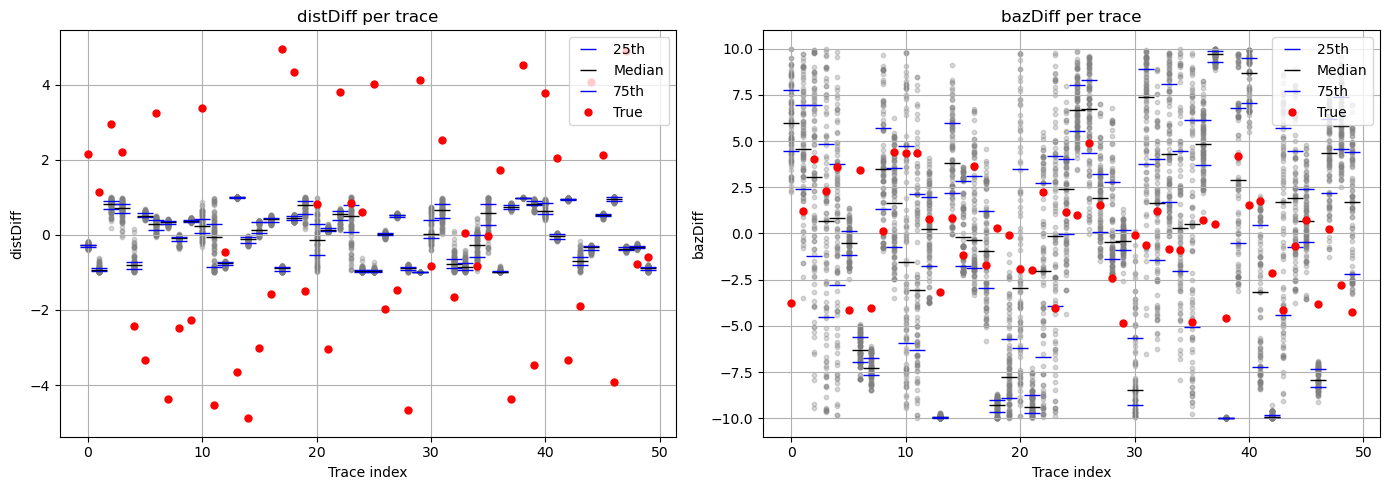

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

def plot_dist_and_baz(ensemble, true_model=None):
    dist_array = np.stack([m.distDiff for m in ensemble])  # (Nmodel, Ntrace)
    baz_array = np.stack([m.bazDiff for m in ensemble])    # (Nmodel, Ntrace)
    _, Ntrace = dist_array.shape

    # Initialize true values if provided
    true_distDiff = true_model.distDiff if true_model is not None else None
    true_bazDiff = true_model.bazDiff if true_model is not None else None

    fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

    for param_array, param_name, true_vals, ax in [
        (dist_array, 'distDiff', true_distDiff, axs[0]),
        (baz_array, 'bazDiff', true_bazDiff, axs[1])
    ]:
        for j in range(Ntrace):
            y_vals = param_array[:, j]
            ax.scatter(np.full_like(y_vals, j), y_vals, alpha=0.3, s=10, color='gray')

            p25, p50, p75 = np.percentile(y_vals, [25, 50, 75])
            ax.plot(j, p25, 'b_', markersize=12, label='25th' if j == 0 else "")
            ax.plot(j, p50, 'k_', markersize=12, label='Median' if j == 0 else "")
            ax.plot(j, p75, 'b_', markersize=12, label='75th' if j == 0 else "")

            if true_vals is not None:
                ax.plot(j, true_vals[j], 'ro', markersize=5, label='True' if j == 0 else "")

        ax.set_title(f'{param_name} per trace')
        ax.set_xlabel('Trace index')
        ax.set_ylabel(param_name)
        ax.grid(True)
        ax.legend(loc='upper right')

    plt.tight_layout()
    plt.show()



# Example usage
isSyn = True
is3c = False
comp = "Z"
modname = "model2"
runname = "run2"

datadir = "./SynData/" if isSyn else "./RealData/"
resdir = "./runs/syn/" if isSyn else "./runs/data/"

with open(os.path.join(resdir, modname, runname, "ensemble.pkl"), "rb") as f:
    ensemble = pickle.load(f)
if isSyn:
    with open(os.path.join(datadir, modname, "Model.pkl"), "rb") as f:
        model = pickle.load(f)

plot_dist_and_baz(ensemble, model)
